In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [3]:
data1 = pd.read_csv('archive/fashion-mnist_train.csv')
data2 = pd.read_csv('archive/fashion-mnist_test.csv')
Y = torch.tensor(data1['label'].to_numpy(), device='cpu') 
data = data1.drop('label', axis = 1)
d = torch.tensor(data.to_numpy(), device=device)

gen = torch.Generator(device=device)
gen.manual_seed(1234)

In [4]:
data_transform = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.1), scale=(0.8, 1)),
    #transforms.transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    ])

In [5]:
aug_ratio = 2
X = d

for a in range(aug_ratio):
    aug = data_transform(d.view(len(d),1,28,28))
    tmp = aug.view(len(d),28*28)
    X = torch.cat((X,tmp), dim=0)
    

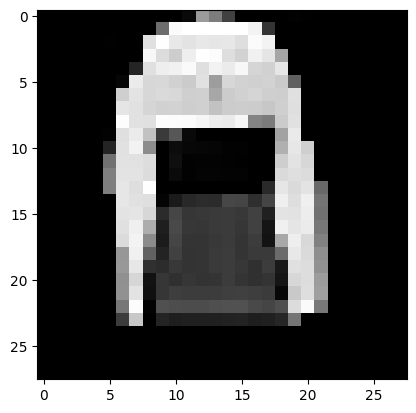

In [6]:
plt.imshow(X[torch.randint(0,len(X), (1,1))].cpu().view(28,28), cmap='gray')

In [7]:
Xn = X / 255
Y = Y.repeat(aug_ratio+1)
Xc = torch.eye(10)[Y].to(device)

In [8]:
class CVAE(nn.Module):
    def __init__(self, lat):
        super().__init__()
        super().__init__()
        self.encoder = nn.Sequential( 
         nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5,5), padding=0), nn.MaxPool2d(2,2), nn.Dropout(0.1) , nn.LeakyReLU(),
         nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(5,5), padding=0), nn.LeakyReLU(),
         nn.Flatten()
         )
        
        self.lat = lat
        self.z_mean = nn.Linear(8**2*16, self.lat)
        self.z_log_var = nn.Linear(8**2*16, self.lat)


        self.decoder = nn.Sequential(nn.Linear(lat+10,8**2*16), nn.Unflatten(1,(16,8,8)),
         nn.ConvTranspose2d(in_channels=16, out_channels=64, kernel_size=(5,5), padding=0) , nn.Upsample(scale_factor=2, mode='bilinear') , nn.Dropout(0.1), nn.LeakyReLU(),
         nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=(5,5), padding=0),  nn.LeakyReLU(),
        )
    

    def forward(self, i, c):
        
        x = self.encoder(i)
        mu = self.z_mean(x)
        log_sig = self.z_log_var(x)
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen, device=device) 
        print(c)
        print(c.shape)
        y = self.decoder(torch.cat((z,c), dim=1))
        
        return i, y, mu, log_sig
    
    @torch.no_grad()
    def generate(self,c):
        
        z = torch.randn((1,self.lat), generator=gen, device=device)
        out = self.decoder(torch.cat((z,c), dim=1))
        return out
    
    @torch.no_grad()
    def decode(self,z,c):

        out = self.decoder(torch.cat((z,c), dim=1))
        return out
    
    @torch.no_grad()
    def encode(self,i):
        
        x = self.encoder(i)
        mu = self.z_mean(x)
        log_sig = self.z_log_var(x)
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen, device=device)
        return z
    
    @torch.no_grad()
    def reproduce(self, i, c):
        
        x = self.encoder(i)
        mu = self.z_mean(x)
        log_sig = self.z_log_var(x)
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen, device=device) + self.condition(c).view(-1,self.lat).to(device)
        y = self.decoder(z)

        return y

In [9]:
class VAE(nn.Module):
    def __init__(self, lat):
        super().__init__()

        self.encoder = nn.Sequential( 
         nn.Linear(28*28+1,18*18), nn.Dropout(0.1), nn.LeakyReLU(),
         nn.Linear(18*18,8*8), nn.Dropout(0.1), nn.LeakyReLU(),
         )
        
        self.condition = nn.Sequential(
            nn.Linear(10,lat), nn.Dropout(0.1), nn.LeakyReLU()
        )
        
        self.lat = lat
        self.z_mean = nn.Linear(8*8, self.lat)
        self.z_log_var = nn.Linear(8*8, self.lat)
        self.drop = nn.Dropout(0.1)

        self.decoder = nn.Sequential(
         nn.Linear(self.lat+1,18*18), nn.Dropout(0.1), nn.LeakyReLU(),
         nn.Linear(18*18,28*28+10), nn.Dropout(0.1)
        )
    

    def forward(self, i, c):
        
        x = self.encoder(i)

        mu = self.drop(self.z_mean(x))
        log_sig = self.drop(self.z_log_var(x))
        
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen).to(device) + self.condition(c).to(device)

        y = self.decoder(z)
        
        return i, y, mu, log_sig, self.lat
    
    @torch.no_grad()
    def generate(self):
        
        out = self.decoder(torch.randn((1,self.lat)))
        return out
    
    @torch.no_grad()
    def decode(self,z):
        
        out = self.decoder(z)
        return out
    
    @torch.no_grad()
    def reproduce(self, i):
        
        x = self.encoder(i)
        mu = self.drop(self.z_mean(x))
        log_sig = self.drop(self.z_log_var(x))
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen) 
        y = self.decoder(torch.cat((i[:,0].view(-1,1),z), dim=1))

        return y

In [10]:
vae = CVAE(2).to(device)

print('The model has', sum(p.numel() for p in vae.parameters() if p.requires_grad), 'trainable parameters' )

optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.3, total_iters=10000)

The model has 71957 trainable parameters


In [11]:
def Loss(x,y,mu,log_sig, beta):

    l = torch.sum(torch.abs(x.view(-1,28*28)-y.view(-1,28*28)))
    #l = nn.functional.binary_cross_entropy(x,y) 
    kl = torch.mean(-0.5*torch.sum(1 + log_sig - mu*mu - torch.exp(log_sig), dim=1), dim=0)
    
    loss = l + beta*kl

    return loss 

In [12]:
batch = 128
loss_eval = 500
tot_epochs = 3
beta = 500

for epoch in range(tot_epochs):

    running_loss = 0.0
    for i in range(len(Xn)//batch):
        
        # Batch of training 
        ix = torch.randint(0, len(Xn), (batch,), generator=gen, device=device)
        
        # Training
        x, y, mu, log_sig = vae(Xn[ix,].view(batch,1,28,28), Xc[ix])
        loss = Loss(x, y, mu, log_sig, beta)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        scheduler.step()

        if i % loss_eval == loss_eval-1:
            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {running_loss/loss_eval:.2f}')
            running_loss = 0.0



tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='mps:0')
torch.Size([128, 10])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]], device='mps:0')
torch.Size([128, 10])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='mps:0')
torch.Size([128, 10])
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
    

KeyboardInterrupt: 

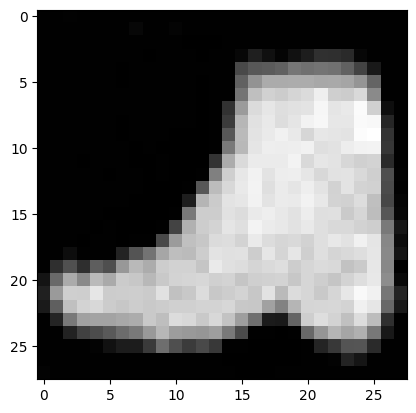

In [ ]:
plt.imshow(vae.generate(torch.eye(10, device=device)[9].view(1,10)).cpu().view(28,28), cmap='gray')

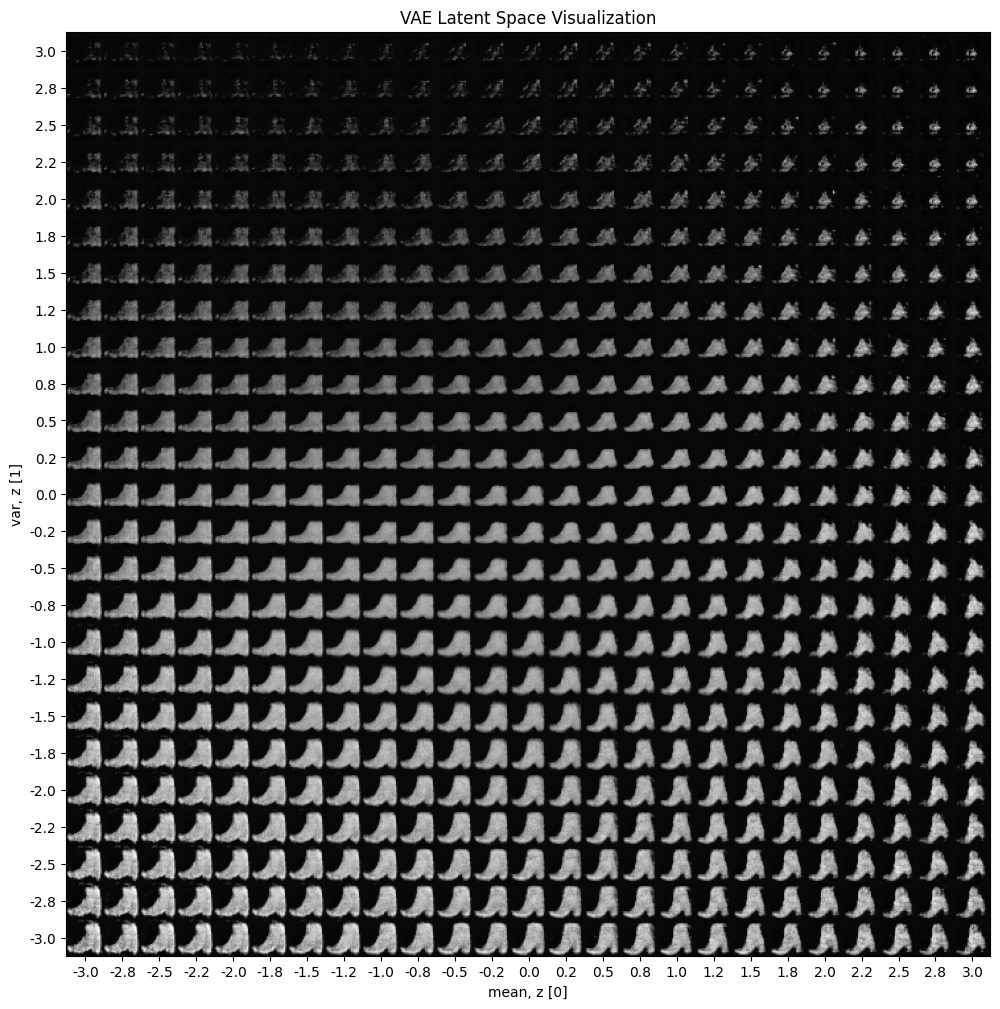

In [ ]:
def plot_latent_space(model, num ,scale=3.0, n=25, digit_size=28, figsize=12):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float, device=device)
            c = torch.eye(10, device=device)[num]
            x_decoded = model.decode(z_sample, c.view(1,10))
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit.cpu()

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae, 9)

In [7]:
print(bool(int('1')))

True
